In [114]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt
import torch
import os
import datetime

In [115]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [143]:
sales_train_validation = pd.read_csv('sales_train_validation.csv')
sales_train_evaluation = pd.read_csv('sales_train_evaluation.csv')
sell_prices = pd.read_csv('sell_prices.csv')
calendar = pd.read_csv('calendar.csv')
sample_submission = pd.read_csv('sample_submission.csv')

In [144]:
calendar['date'] = pd.to_datetime(calendar['date'])

In [145]:
calendar['combined_event_type'] = calendar.apply(
    lambda row: row['event_type_1'] if pd.isnull(row['event_type_2'])
    else row['event_type_1'] + ' & ' + row['event_type_2'],
    axis=1
)

In [146]:
'''Data pre-processing'''

'Data pre-processing'

In [147]:
item_category_sales = sales_train_validation.groupby(['item_id', 'cat_id']).sum().iloc[:, -1913:].sum(axis=1).reset_index()

item_category_sales.columns = ['item_id', 'cat_id', 'total_sales']

top_10_per_category = item_category_sales.sort_values(['cat_id', 'total_sales'], ascending=[True, False]).groupby('cat_id').head(10)

sales_train_validation = sales_train_validation.loc[sales_train_validation['item_id'].isin(top_10_per_category['item_id'])]
sales_train_evaluation = sales_train_evaluation.loc[sales_train_evaluation['item_id'].isin(top_10_per_category['item_id'])]

<ipython-input-147-cd941252ab85>:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  item_category_sales = sales_train_validation.groupby(['item_id', 'cat_id']).sum().iloc[:, -1913:].sum(axis=1).reset_index()


In [148]:
# Melt sales data to long format
sales_train_validation = pd.melt(sales_train_validation, id_vars=['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'], var_name='day', value_name='sales')
sales_train_validation['day'] = sales_train_validation['day'].apply(lambda x: x[2:]).astype(int)
data = pd.merge(sales_train_validation, calendar, left_on='day', right_on=calendar['d'].apply(lambda x: x[2:]).astype(int), how='left')
data['date'] = pd.to_datetime(data['date'])
data = pd.merge(data, sell_prices, on=['store_id', 'item_id', 'wm_yr_wk'], how='left')

In [149]:
#Evaluation Dataset
sales_train_evaluation = pd.melt(sales_train_evaluation, id_vars=['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'], var_name='day', value_name='sales')
sales_train_evaluation['day'] = sales_train_evaluation['day'].apply(lambda x: x[2:]).astype(int)
eval_data = pd.merge(sales_train_evaluation, calendar, left_on='day', right_on=calendar['d'].apply(lambda x: x[2:]).astype(int), how='left')
eval_data['date'] = pd.to_datetime(eval_data['date'])
eval_data = pd.merge(eval_data, sell_prices, on=['store_id', 'item_id', 'wm_yr_wk'], how='left')

In [150]:
# Create a list of all the event/holiday columns
event_columns = [col for col in data.columns if 'event' in col]

# Create a new column 'is_event_or_holiday' that is True if any event/holiday is True, False otherwise
data['is_event_or_holiday'] = data[event_columns].any(axis=1)
eval_data['is_event_or_holiday'] = eval_data[event_columns].any(axis=1)

In [151]:
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

data['weekday'] = pd.Categorical(data['weekday'], categories=days_order, ordered=True)
eval_data['weekday'] = pd.Categorical(eval_data['weekday'], categories=days_order, ordered=True)

In [152]:
data.sort_values(by=['id', 'date'], inplace=True)
eval_data.sort_values(by=['id', 'date'], inplace=True)

In [ ]:
''' Group and Create Lagged Features
data['sales_lag_1'] = data.groupby(['id'])['sales'].shift(1)
data['sales_lag_7'] = data.groupby(['id'])['sales'].shift(7)
data['sales_lag_30'] = data.groupby(['id'])['sales'].shift(30)

eval_data['sales_lag_1'] = eval_data.groupby(['id'])['sales'].shift(1)
eval_data['sales_lag_7'] = eval_data.groupby(['id'])['sales'].shift(7)
eval_data['sales_lag_30'] = eval_data.groupby(['id'])['sales'].shift(30)

data['sales_rolling_mean_7'] = data.groupby(['id'])['sales'].transform(lambda x: x.rolling(7).mean())
data['sales_rolling_mean_28'] = data.groupby(['id'])['sales'].transform(lambda x: x.rolling(28).mean())
data['sales_rolling_std_7'] = data.groupby(['id'])['sales'].transform(lambda x: x.rolling(7).std())
data['sales_rolling_std_28'] = data.groupby(['id'])['sales'].transform(lambda x: x.rolling(28).std())

eval_data['sales_rolling_mean_7'] = eval_data.groupby(['id'])['sales'].transform(lambda x: x.rolling(7).mean())
eval_data['sales_rolling_mean_28'] = eval_data.groupby(['id'])['sales'].transform(lambda x: x.rolling(28).mean())
eval_data['sales_rolling_std_7'] = eval_data.groupby(['id'])['sales'].transform(lambda x: x.rolling(7).std())
eval_data['sales_rolling_std_28'] = eval_data.groupby(['id'])['sales'].transform(lambda x: x.rolling(28).std())

chunk_size = 100000
num_chunks = len(data) // chunk_size + 1

processed_data = []

for i in range(num_chunks):
    start_index = i * chunk_size
    end_index = (i + 1) * chunk_size
    chunk = data.iloc[start_index:end_index].copy()

    # Apply the operation on the chunk
    chunk.dropna(subset=['sales_lag_30'], inplace=True)

    # You can then save this chunk to a new dataframe or a list
    processed_data.append(chunk)

data = pd.concat(processed_data, ignore_index=True)

chunk_size = 100000
num_chunks = len(eval_data) // chunk_size + 1

processed_data = []

for i in range(num_chunks):
    start_index = i * chunk_size
    end_index = (i + 1) * chunk_size
    chunk = eval_data.iloc[start_index:end_index].copy()

    # Apply the operation on the chunk
    chunk.dropna(subset=['sales_lag_30'], inplace=True)

    # You can then save this chunk to a new dataframe or a list
    processed_data.append(chunk)

eval_data = pd.concat(processed_data, ignore_index=True)

'''

In [153]:
data['day_of_week'] = data['date'].dt.dayofweek
data['week_of_year'] = data['date'].dt.isocalendar().week
data['start_of_month'] = (data['date'].dt.day == 1).astype(int)
data['is_august'] = (data['month'] == 8).astype(int)
data['is_weekend'] = (data['day_of_week'] >= 5).astype(int)

In [154]:
eval_data['day_of_week'] = eval_data['date'].dt.dayofweek
eval_data['week_of_year'] = eval_data['date'].dt.isocalendar().week
eval_data['start_of_month'] = (eval_data['date'].dt.day == 1).astype(int)
eval_data['is_august'] = (eval_data['month'] == 8).astype(int)
eval_data['is_weekend'] = (eval_data['day_of_week'] >= 5).astype(int)

In [155]:
data['snap_CA_sales'] = np.where(data['state_id'] == 'CA', data['snap_CA'] * data['sales'], 0)
data['snap_TX_sales'] = np.where(data['state_id'] == 'TX', data['snap_TX'] * data['sales'], 0)
data['snap_WI_sales'] = np.where(data['state_id'] == 'WI', data['snap_WI'] * data['sales'], 0)

In [156]:
eval_data['snap_CA_sales'] = np.where(eval_data['state_id'] == 'CA', eval_data['snap_CA'] * eval_data['sales'], 0)
eval_data['snap_TX_sales'] = np.where(eval_data['state_id'] == 'TX', eval_data['snap_TX'] * eval_data['sales'], 0)
eval_data['snap_WI_sales'] = np.where(eval_data['state_id'] == 'WI', eval_data['snap_WI'] * eval_data['sales'], 0)

In [157]:
data['snap'] = 0

# Set 'snap' based on the state that a product belongs to
data.loc[data['state_id'] == 'CA', 'snap'] = data['snap_CA']
data.loc[data['state_id'] == 'TX', 'snap'] = data['snap_TX']
data.loc[data['state_id'] == 'WI', 'snap'] = data['snap_WI']

#Evaluation dataset
eval_data['snap'] = 0

eval_data.loc[eval_data['state_id'] == 'CA', 'snap'] = eval_data['snap_CA']
eval_data.loc[eval_data['state_id'] == 'TX', 'snap'] = eval_data['snap_TX']
eval_data.loc[eval_data['state_id'] == 'WI', 'snap'] = eval_data['snap_WI']

In [159]:
categorical_columns = ['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id','d', 'event_name_1', 'event_type_1', 'event_name_2', 'event_type_2', 'combined_event_type']
for col in categorical_columns:
    data[col] = data[col].astype('category').cat.codes

In [160]:
categorical_columns = ['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id','d', 'event_name_1', 'event_type_1', 'event_name_2', 'event_type_2', 'combined_event_type']
for col in categorical_columns:
    eval_data[col] = eval_data[col].astype('category').cat.codes

In [161]:
eval_data = eval_data.groupby('id').apply(lambda x: x.tail(28))
eval_data.reset_index(drop=True, inplace=True)

In [ ]:
'''LSTM Model'''

'LSTM Model'

In [162]:
min_date = data['date'].min()
max_date = data['date'].max()
print("Minimum Date:", min_date)
print("Maximum Date:", max_date)

Minimum Date: 2011-01-29 00:00:00
Maximum Date: 2016-04-24 00:00:00


In [163]:
date_range = pd.date_range(start=min_date, end=max_date)
print("Number of Dates:", len(date_range))

Number of Dates: 1913


In [164]:
dfs = []
unique_ids = data['id'].unique()
for product_id in unique_ids:
    product_data = data[data['id'] == product_id]
    product_data = product_data.set_index('date').reindex(date_range).ffill().reset_index()
    product_data['id'] = product_id
    dfs.append(product_data)

In [165]:
full_data = pd.concat(dfs, ignore_index=True)

In [72]:
print("Shape of full_data:", full_data.shape)

Shape of full_data: (57390, 34)


In [166]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("CUDA is available. Running on GPU.")
else:
    device = torch.device("cpu")
    print("CUDA is not available. Running on CPU.")

CUDA is available. Running on GPU.


In [167]:
features = ['item_id', 'state_id', 'store_id',
            'is_weekend', 'start_of_month', 'combined_event_type',
            'snap_CA', 'snap_TX', 'snap_WI']

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_features = scaler.fit_transform(full_data[features])

scaled_features_df = pd.DataFrame(scaled_features, columns=features)
sales_scaler = MinMaxScaler(feature_range=(0, 1))
scaled_sales = sales_scaler.fit_transform(full_data[['sales']].values)
scaled_features_df['sales'] = scaled_sales
scaled_features_df['id'] = full_data['id'].values

print(scaled_features_df.shape)

#Evaluation dataset
scaled_eval_features = scaler.transform(eval_data[features])
scaled_eval_features_df = pd.DataFrame(scaled_eval_features, columns=features)
scaled_eval_sales = sales_scaler.transform(eval_data[['sales']].values)
scaled_eval_features_df['sales'] = scaled_eval_sales
scaled_eval_features_df['id'] = eval_data['id'].values

(573900, 11)


In [ ]:
def create_sequences(data, time_steps):
    X, y = [], []
    for i in range(len(data) - time_steps - 1):
        X.append(data[i:(i + time_steps), :-1])
        y.append(data[i + time_steps, -1])
    return np.array(X), np.array(y)

In [169]:
def create_sequences_by_product(data, time_steps):
    sequences = {}
    for product_id in unique_ids:
        product_data = data[data['id'] == product_id].drop('id', axis=1)
        X, y = create_sequences(product_data.values, time_steps)
        sequences[product_id] = (X, y)
    return sequences


In [171]:
def predict_next_28_days(data, trained_model, time_steps=365):
    predictions = []
    for i in range(28):  # predict next 28 days
        seq = data[-time_steps:]
        pred = trained_model.predict(seq.reshape(1, time_steps, -1))[0][0]
        predictions.append(pred)
        new_row = np.array(list(seq[-1, 1:]) + [pred])
        data = np.vstack([data, new_row])
    return predictions

In [172]:
TIME_STEPS = 365
sequences_by_product = create_sequences_by_product(scaled_features_df, TIME_STEPS)

In [173]:
start_time = datetime.datetime.now()


columns = ['Product_ID', 'Actual', 'Predicted']
results_df = pd.DataFrame(columns=columns)
future_predictions_df = pd.DataFrame(columns=['Product_ID'] + [f'Day_{i}' for i in range(1, 29)])

TEST_SIZE = 180

for i, product_id in enumerate(unique_ids):
    X, y = sequences_by_product[product_id]

    train_size = len(X) - TEST_SIZE
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]


    model = Sequential()
    model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(50, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(50))
    model.add(Dropout(0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(X_train, y_train, epochs=10, batch_size=72, validation_data=(X_test, y_test), verbose=0, shuffle=False)


    predictions = model.predict(X_test)

    inv_y_test = sales_scaler.inverse_transform(y_test.reshape(-1, 1))
    inv_predictions = sales_scaler.inverse_transform(predictions.reshape(-1, 1))

    temp_df = pd.DataFrame({
        'Product_ID': [product_id] * len(inv_y_test),
        'Actual': inv_y_test.flatten(),
        'Predicted': inv_predictions.flatten()
    })

    print(product_id)

    results_df = pd.concat([results_df, temp_df], ignore_index=True)

    product_data = scaled_features_df[scaled_features_df['id'] == product_id].drop('id', axis=1)
    eval_product_data = scaled_eval_features_df[scaled_eval_features_df['id'] == product_id].drop('id', axis=1)
    future_input = np.concatenate((product_data.values[-TIME_STEPS:], eval_product_data.values))
    future_preds = predict_next_28_days(future_input, model, TIME_STEPS)
    inv_future_preds = sales_scaler.inverse_transform(np.array(future_preds).reshape(-1, 1))

    future_predictions_list = inv_future_preds.flatten()

    product_list = [product_id] * 28
    day_list = list(range(1, 29))

    future_temp_df = pd.DataFrame({
        'Product_ID': product_list,
        'Day': day_list,
        'Predicted': future_predictions_list
    })


    future_predictions_df = pd.concat([future_predictions_df, future_temp_df], ignore_index=True)

end_time = datetime.datetime.now()
duration = end_time - start_time

print(results_df)


Streaming output truncated to the last 5000 lines.
6/6 [==============================] - 1s 14ms/step
134
6/6 [==============================] - 1s 15ms/step
135
6/6 [==============================] - 1s 14ms/step
136
6/6 [==============================] - 1s 14ms/step
137
6/6 [==============================] - 1s 14ms/step
138
6/6 [==============================] - 1s 14ms/step
139
6/6 [==============================] - 1s 14ms/step
140
6/6 [==============================] - 1s 14ms/step
141
6/6 [==============================] - 1s 14ms/step
142
6/6 [==============================] - 2s 14ms/step
143
6/6 [==============================] - 1s 14ms/step
144
6/6 [==============================] - 1s 15ms/step
145
6/6 [==============================] - 1s 14ms/step
146
6/6 [==============================] - 1s 14ms/step
147
6/6 [==============================] - 1s 15ms/step
148
6/6 [==============================] - 1s 14ms/step
149
6/6 [==============================] - 1s 14ms/step
1

In [174]:
future_predictions_df['actual'] = eval_data['sales']

In [177]:
rmse = np.sqrt(mean_squared_error(results_df['Actual'], results_df['Predicted']))
mae = mean_absolute_error(results_df['Actual'], results_df['Predicted'])
print(f'Test RMSE: {rmse:.3f}, Test MAE: {mae:.3f}')

Test RMSE: 10.737, Test MAE: 6.231


In [180]:
cols_to_drop = [f"Day_{i}" for i in range(1, 29)] + ["Day"]
df_cleaned = future_predictions_df.drop(columns=cols_to_drop)

In [182]:
df_cleaned['date'] = eval_data['date']

In [178]:
print('Total time taken:', duration.total_seconds() / 60, 'minutes')

Total time taken: 95.1795992 minutes


In [37]:
last_180_dates = data['date'].tail(180).values

repeated_dates = np.tile(last_180_dates, data['id'].nunique())

unique_products = eval_data['id'].unique() 
product_ids = np.repeat(unique_products, 180) 

In [38]:
results_df['date'] = repeated_dates

In [39]:
grouped_eval_data = data.groupby('date')['sales'].sum().reset_index()
grouped_eval_data.columns = ['date', 'Actual']
grouped_predicted_data = results_df.groupby('date')['Predicted'].sum().reset_index()

In [40]:
merged_data = pd.merge(grouped_predicted_data, grouped_eval_data, on='date', how='left')

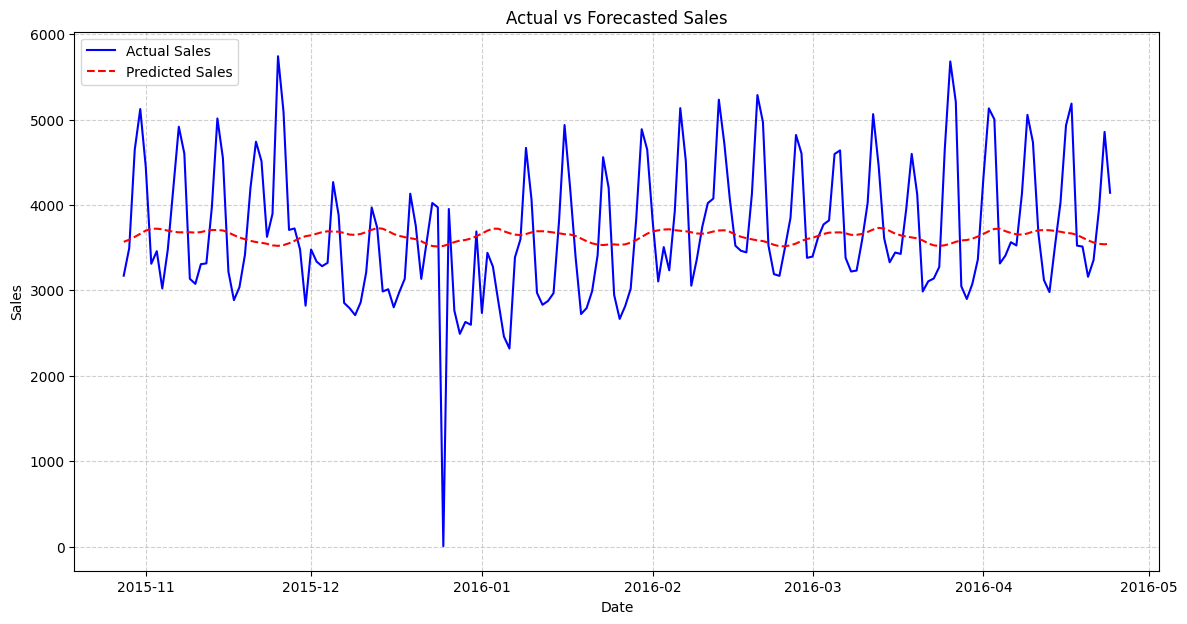

In [50]:
plt.figure(figsize=(14, 7))

plt.plot(merged_data['date'], merged_data['Actual'], label='Actual Sales', color='blue')
plt.plot(merged_data['date'], merged_data['Predicted'], label='Predicted Sales', color='red', linestyle='--')

plt.title('Actual vs Forecasted Sales')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend(loc='upper left')
plt.grid(True, linestyle='--', alpha=0.6)

plt.show()

In [183]:
results_df.to_excel("LSTM_results.xlsx", index=False, engine='openpyxl')
df_cleaned.to_excel("LSTM_results_28.xlsx", index=False, engine='openpyxl')

'''from google.colab import files

# Trigger the file download
files.download("LSTM_results.xlsx")
files.download("LSTM_results_28.xlsx")'''

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

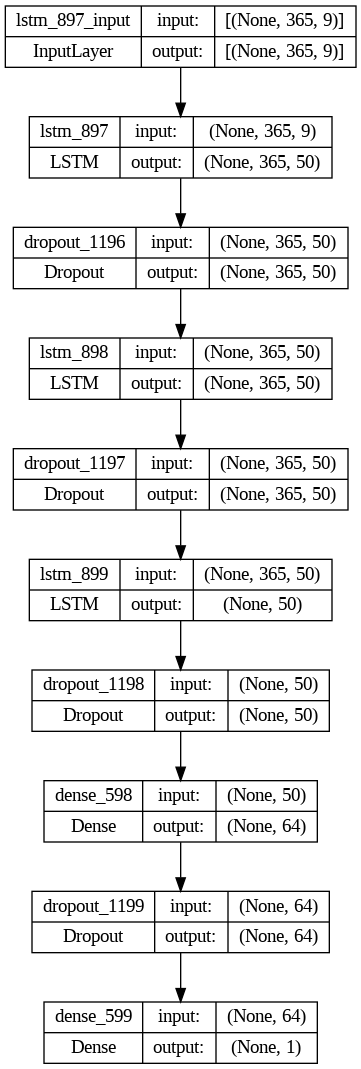

In [52]:
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)
